# Notes

This notebook finds the best distribution to fit a set of data with.

It is adapted from:

https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

It is used to find the best distribution to fit contributions to DM from halo structures.

The data which will be investigated was created at:

Illustris_Zhang_Method/Pipe_LSS_Analysis_5.ipynb

and is stored at:

Illustris_Zhang_Method/Stored_Pipe_DM_Values/

Outcome: by eye, by running this multiple times on different snaps, it looks like a fisk or gilbrat may be the best function to use?

# Imports

In [50]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
from matplotlib import pyplot as plt

In [268]:
#Choose simulation, data to load
sim_to_load = 'TNG300-1'
snap = 78

#load data
DMs_Hal_data = np.load('./Stored_Pipe_DM_Values/Hal_DMs_sim_{0}_snap_{1}.npy'.format(sim_to_load,snap))

#log as easier to fit
data=np.log(data)
#get rid of negative values (which go nan when you log)
tokeep = np.invert(np.isnan(np.log(data)))
data = data[tokeep]

#put data into suitable form for the code to use (only take every x steps for speed)
steps = 100#0000
data = pd.Series(DMs_Hal_data[0::steps])

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


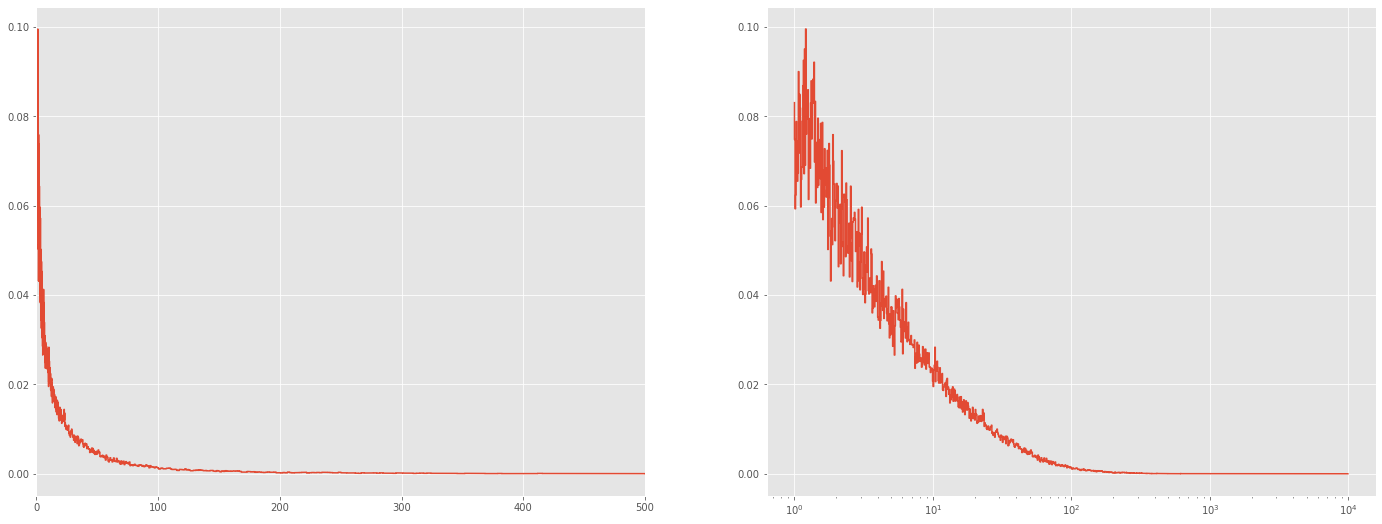

In [269]:
#re-histogram the raw data as a check
bin_edges_new = np.logspace(0,4,num=1000)
count_check,bin_check=np.histogram(data,bin_edges_new,density=True)

#plot it (normal and log x-axis)
fig = plt.figure(figsize=(24,9))
ax1 = fig.add_subplot(121)
ax1.set_xlim([0,500])
ax2 = fig.add_subplot(122)
ax2.set_xscale('log')

#plot on normal x axis
ax1.step(bin_check[:-1],count_check)

#plot on log x axis
ax2.step(bin_check[:-1],count_check)


  1 / 100: ksone
  2 / 100: kstwobign
  3 / 100: norm
  4 / 100: alpha
  5 / 100: anglit
  6 / 100: arcsine
  7 / 100: beta
  8 / 100: betaprime
  9 / 100: bradford
 10 / 100: burr
 11 / 100: burr12
 12 / 100: fisk
 13 / 100: cauchy
 14 / 100: chi
 15 / 100: chi2
 16 / 100: cosine
 17 / 100: dgamma
 18 / 100: dweibull
 19 / 100: expon
 20 / 100: exponnorm
 21 / 100: exponweib
 22 / 100: exponpow
 23 / 100: fatiguelife
 24 / 100: foldcauchy
 25 / 100: f
 26 / 100: foldnorm
 27 / 100: weibull_min
 28 / 100: weibull_max
 29 / 100: frechet_r
 30 / 100: frechet_l
 31 / 100: genlogistic
 32 / 100: genpareto
 33 / 100: genexpon
 34 / 100: genextreme
 35 / 100: gamma
 36 / 100: erlang
 37 / 100: gengamma
 38 / 100: genhalflogistic
 39 / 100: gompertz
 40 / 100: gumbel_r
 41 / 100: gumbel_l
 42 / 100: halfcauchy
 43 / 100: halflogistic
 44 / 100: halfnorm
 45 / 100: hypsecant
 46 / 100: gausshyper
 47 / 100: invgamma
 48 / 100: invgauss
 49 / 100: geninvgauss
 50 / 100: norminvgauss
 51 / 100: 

Text(0, 0.5, 'Fit')

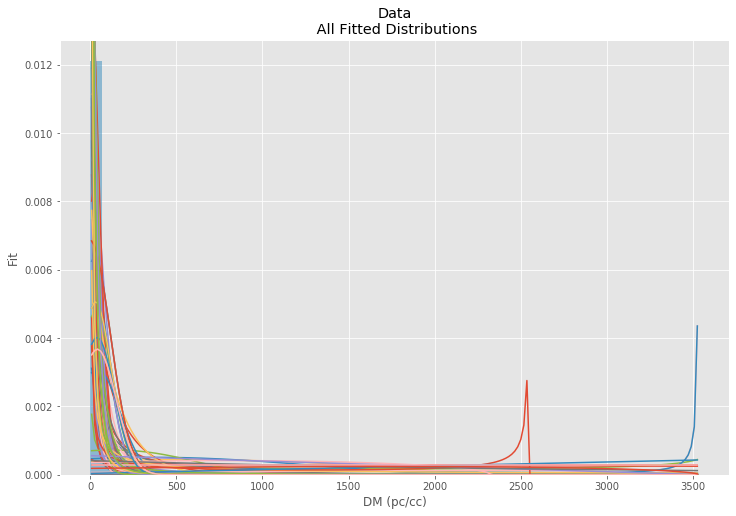

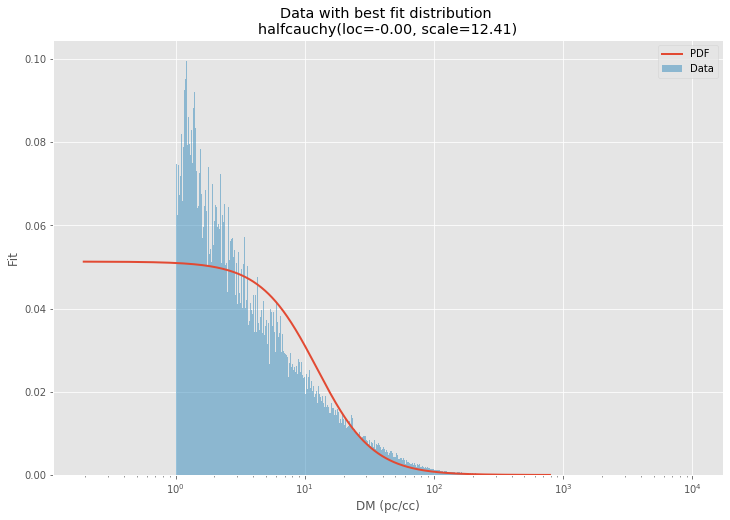

In [270]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
#data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
data = data

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Data\n All Fitted Distributions')
ax.set_xlabel(u'DM (pc/cc)')
ax.set_ylabel('Fit')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=np.logspace(0,4,num=1000), density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'Data with best fit distribution \n' + dist_str)
ax.set_xlabel(u'DM (pc/cc)')
ax.set_xscale('log')
ax.set_ylabel('Fit')

In [271]:
from scipy.stats import gilbrat,fisk,gumbel_l,foldcauchy,halfcauchy

#data to hist/fit
dat=np.load('./Stored_Pipe_DM_Values/Hal_DMs_sim_TNG300-1_snap_78.npy')[0::10]
#log because a gumbel fits better
dat=np.log(dat)
#get rid of negative values (which go nan when you log)
tokeep = np.invert(np.isnan(np.log(dat)))
dat = dat[tokeep]

#histogram
bin_edges_new = np.logspace(0,4,num=1000)
count_check,bin_check=np.histogram(dat,bin_edges_new,density=True)

#print(fisk.fit(dat))
#fit
#gilbrat_loc,gilbrat_scale = gilbrat.fit(dat,loc=-100)
fisk_c,fisk_loc,fisk_scale = fisk.fit(dat)
#foldcauchy_c,foldcauchy_loc,foldcauchy_scale = foldcauchy.fit(dat,loc=0)
gumbel_l_loc,gumbel_l_scale=gumbel_l.fit(dat,loc=-4,scale=4)
hc_loc,hc_scale=halfcauchy.fit(dat,loc=0,scale=12)


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:3125: RuntimeWarning: overflow encountered in exp
  return x - np.exp(x)


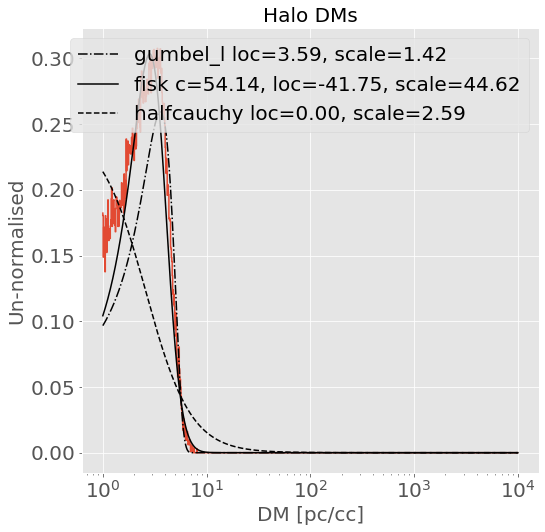

In [273]:
 fig = plt.figure(figsize=(18,18))


#second subplot: DM from halos
ax2 = fig.add_subplot(222)
ax2.set_title('Halo DMs',fontsize=20)
ax2.set_xlabel('DM [pc/cc]',fontsize=20)
ax2.set_ylabel('Un-normalised',fontsize=20)
ax2.set_xscale('log')
ax2.tick_params(axis='both',which='major',labelsize=20)

ax2.step(bin_check[:-1],count_check)

#g = gilbrat.pdf(x=bin_edges_new,loc=gilbrat_loc,scale=gilbrat_scale) #fitted pdf
#ax2.plot(bin_edges_new,g,color='k',ls='--',label='gilbrat loc={0:.2f}, scale={1:.2f}'.format(gilbrat_loc,gilbrat_scale)) #plot fit

gl = gumbel_l.pdf(x=bin_edges_new,loc=gumbel_l_loc,scale=gumbel_l_scale) #fitted pdf
ax2.plot(bin_edges_new,gl,color='k',ls='-.',label='gumbel_l loc={0:.2f}, scale={1:.2f}'.format(gumbel_l_loc,gumbel_l_scale)) #plot fit

f = fisk.pdf(x=bin_edges_new,c=fisk_c,loc=fisk_loc,scale=fisk_scale) #fitted pdf
ax2.plot(bin_edges_new,f,color='k',label='fisk c={0:.2f}, loc={1:.2f}, scale={2:.2f}'.format(fisk_c,fisk_loc,fisk_scale)) #plot fit

hc = halfcauchy.pdf(x=bin_edges_new,loc=hc_loc,scale=hc_scale)
ax2.plot(bin_edges_new,hc,color='k',ls='--',label='halfcauchy loc={0:.2f}, scale={1:.2f}'.format(hc_loc,hc_scale)) #plot fit

#fc = foldcauchy.pdf(x=bin_edges_new,c=foldcauchy_c,loc=foldcauchy_loc,scale=foldcauchy_scale) #fitted pdf
#ax2.plot(bin_edges_new,fc,color='k',ls='-.',label='foldcauchy c={0:.2f}, loc={1:.2f}, scale={2:.2f}'.format(foldcauchy_c,foldcauchy_loc,foldcauchy_scale)) #plot fit

ax2.legend(fontsize=20)
plt.show()

In [190]:
dat
np.sum(np.isnan(np.log(dat)))

/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


713